# Fitting a Line Using MCMC
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 30)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

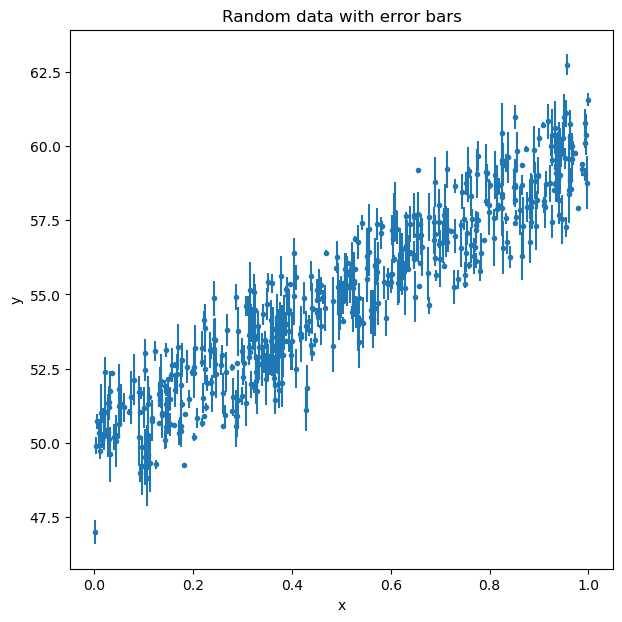

In [2]:
N = 500  # number of points
true_m = 10.  # slope
true_b = 50.  # intercept
sigma = 1.  # scatter

rng = np.random.default_rng(293746)
x =  rng.random((N,)) # complete with random values between 0 and 1
y =  (true_m * x + true_b) + np.random.normal(0, sigma, size=N)
# equation for a line PLUS random values from a Gaussian centered at 0 with standard deviation `sigma`
dy =  rng.random((N,)) # array of error bars for all the data (all `sigma`)

# plot your generated data with error bars
fig, ax = plt.subplots(figsize=(7,7))
ax.errorbar(x,y,dy,fmt='.')
ax.set_title("Random data with error bars")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [23]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_prior(theta):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """

    if theta[0] > m_min and theta[0] < m_max:
    
        ln_prior1 = -np.log(1/theta[0])

    else:
        ln_prior1 = -np.inf
    
    
    if theta[1] > b_min and theta[1] < b_max:
        
        ln_prior2 = -np.log(1/theta[1])
        
    else:
        ln_prior2 = -np.inf
        
    ln_prior = ln_prior1 + ln_prior2
    
    return ln_prior


def log_likelihood(theta, x, y, dy):
    """
    Returns log(likelihood) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
    
    Returns
    -------
    ln_likelihood: float
        Natural log of the likelihood probability function
    """
    
    y_model = x * theta[0] + theta[1]
    
    all_ln_likelihoods = -1 * 0.5  *  ( np.log(2 * np.pi * sigma ** 2) + ( ( (y - y_model)  /  sigma)  ** 2))
                          
    ln_likelihood = np.sum(all_ln_likelihoods)
    
    return ln_likelihood


def log_posterior(theta, x, y, dy):
    """
    Returns log(posterior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
        
    x: list, array-like
        List of independent variables from data
        
    y: list, array-like
        List of dependent variables from data
        
    dy: list, array-like
        List of errors from your y-data
        
    Returns
    -------
    ln_posterier: float
        Natural log of the posterior probabilty function
    """
    ln_likelihood = log_likelihood(theta, x, y, dy)
    ln_prior = log_prior(theta)

    ln_posterior = ln_likelihood + ln_prior
    
    return ln_posterior

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

Note, we will initialise the sampler in #1.5

In [28]:
n_walkers = 100
n_params = 2

sample =  emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=(x,y,dy))

## Setup random initial guesses for the starting positions

You'll need to give initial guesses for each walker, which you can draw randomly from the prior. 

In [25]:
m_random =  np.random.uniform(5,15,size=100)
b_random =  np.random.uniform(45,55,size=100)
initial_guesses =  np.vstack([m_random, b_random]).T
print(np.shape(initial_guesses))
print(type(initial_guesses))

(100, 2)
<class 'numpy.ndarray'>


## Initialize and run!

Initialize the `EnsembleSampler` object and then run it with the `run_mcmc` method. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [26]:
print(emcee.__version__)

3.1.6


In [29]:
# initialize the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=(x,y,dy))

n_steps = 1000

# run!
sampler.run_mcmc(initial_guesses, n_steps, progress=True)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 543.00it/s]


State([[10.17081623 49.87883735]
 [ 9.93490926 49.99453055]
 [ 9.90598371 50.03183261]
 [ 9.80139475 50.02352395]
 [10.03965845 49.94522432]
 [10.07612793 49.9417255 ]
 [10.12042298 49.92956931]
 [10.32031289 49.83024679]
 [10.22480705 49.72411538]
 [ 9.46516558 50.1772793 ]
 [ 9.97371758 49.94394854]
 [ 9.93582084 49.9407789 ]
 [ 9.9797563  49.89648061]
 [ 9.84890058 49.93063988]
 [ 9.87145921 49.96483289]
 [ 9.83938121 50.02917813]
 [ 9.73421202 49.97335926]
 [ 9.83263342 50.01561831]
 [10.0642862  49.86302803]
 [ 9.98441203 49.98061066]
 [ 9.80997877 50.03042917]
 [ 9.89155968 50.05787918]
 [ 9.80685914 49.97682923]
 [ 9.79182153 49.97563864]
 [ 9.95750666 50.01619339]
 [ 9.83279258 50.02049492]
 [ 9.96149273 49.94060636]
 [10.01361347 49.92342109]
 [ 9.8039311  50.0478864 ]
 [ 9.91927226 49.96882201]
 [ 9.92410319 49.93350284]
 [ 9.83365854 50.04460396]
 [10.04854577 49.91615363]
 [ 9.92510385 49.96138057]
 [ 9.76339412 50.08063944]
 [ 9.90190443 49.93887366]
 [10.0510836  49.92996

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

(100, 1000, 2)


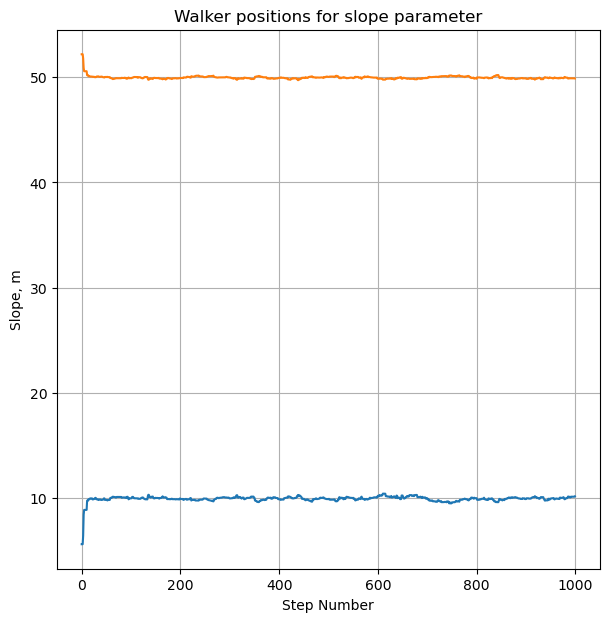

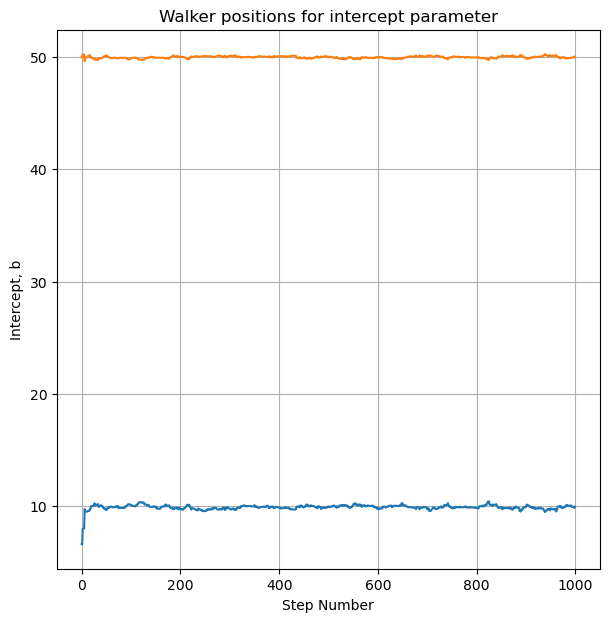

In [44]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    
    n_walkers, n_steps, n_params =  chain.shape
    
    plt.figure(figsize=(7,7))
    plt.plot(chain[:][:][0], **kwargs)
    plt.title('Walker positions for slope parameter')
    plt.xlabel('Step Number')
    plt.ylabel('Slope, m')
    plt.grid()

    plt.figure(figsize=(7,7))
    plt.plot(chain[:][:][1], **kwargs)
    plt.title('Walker positions for intercept parameter')
    plt.xlabel('Step Number')
    plt.ylabel('Intercept, b')
    plt.grid()

chain_plots(sampler.chain)

Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice? --> I see that once the mcmc fit finds a good sample, it only samples around that one!

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

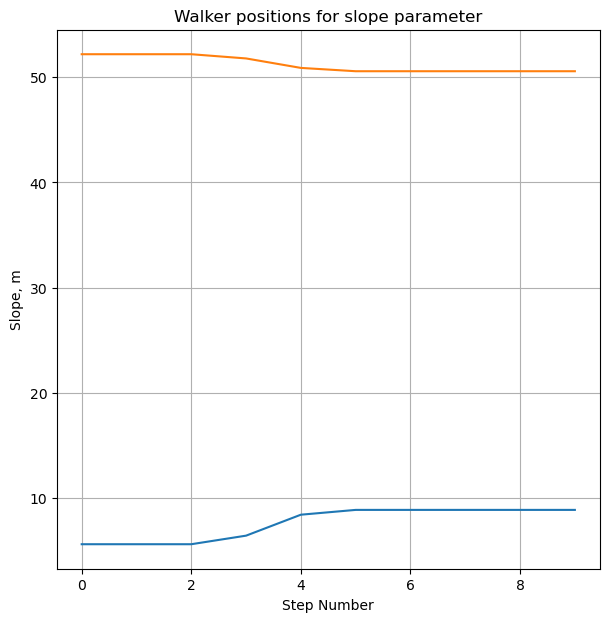

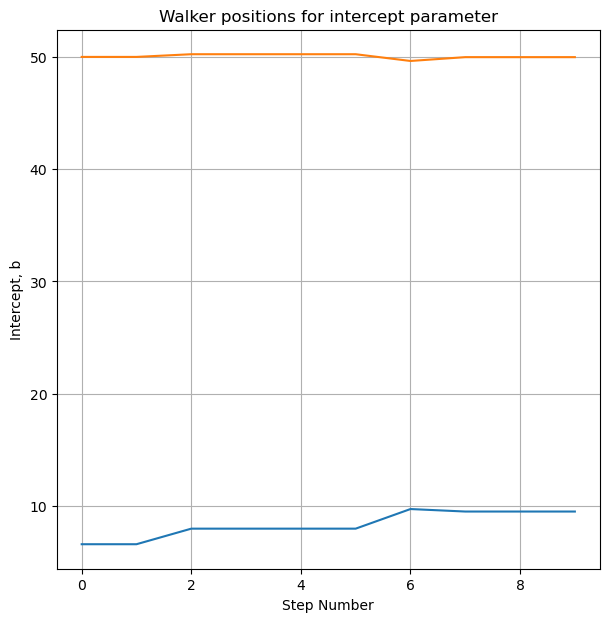

In [47]:
n_burn =  10
burn_chain =  sampler.chain[:, :n_burn, :]
chain_plots(burn_chain)

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. 
--> It took only 6 steps maximum to converge.

**From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

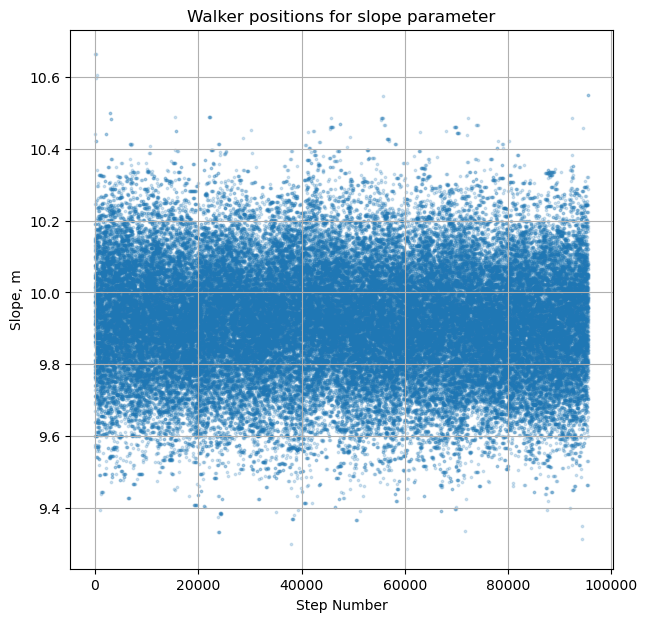

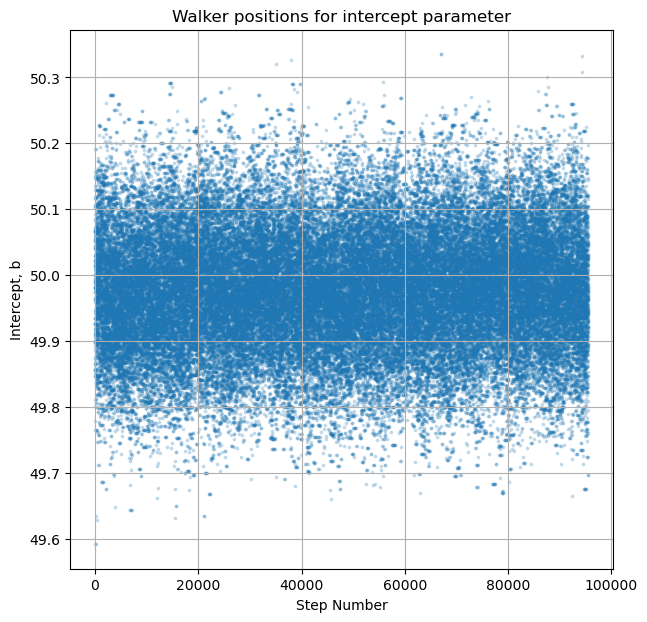

In [82]:
# create flat chain with no burn=in
flat_chain =  sampler.get_chain(discard=45, flat=True)
m_mcmc =  []
b_mcmc =  []
for i in range(flat_chain.shape[0]):
    m_mcmc.append(flat_chain[i][0])
    b_mcmc.append(flat_chain[i][1])

step_number =  [step for step in range(len(m_mcmc))]
    
plt.figure(figsize=(7,7))
plt.scatter(step_number, m_mcmc, s=3, alpha = 0.2)
plt.title('Walker positions for slope parameter')
plt.xlabel('Step Number')
plt.ylabel('Slope, m')
plt.grid()

plt.figure(figsize=(7,7))
plt.scatter(step_number, b_mcmc, s=3, alpha = 0.2)
plt.title('Walker positions for intercept parameter')
plt.xlabel('Step Number')
plt.ylabel('Intercept, b')
plt.grid()

How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)? --> These samples are much much more localized to the correct value whereas just Monte Carlo is an accept-reject method.

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

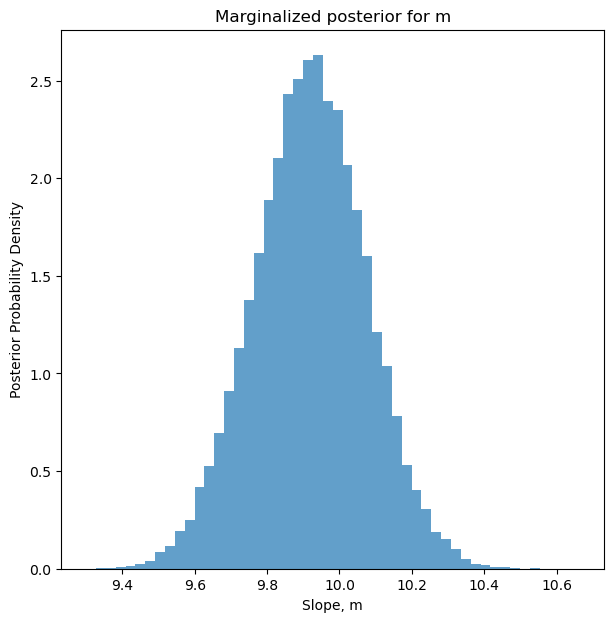

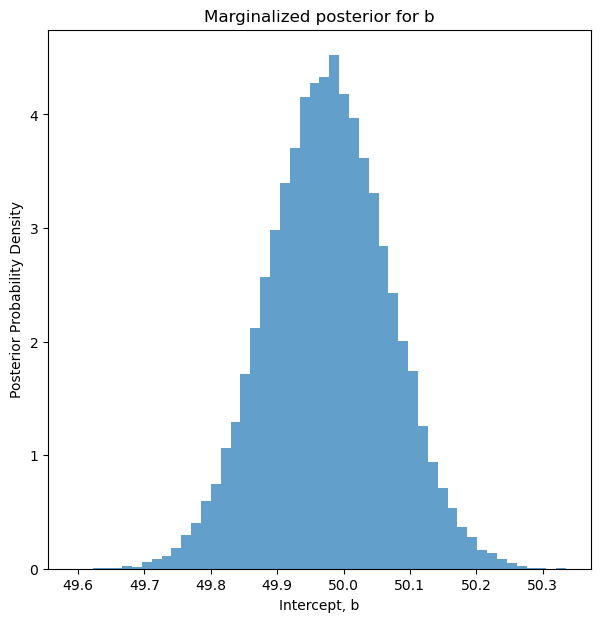

In [85]:
# I can look at the frequency of the values that are drawn
# from mcmc to see the marginalization over each param.

plt.figure(figsize=(7,7))
plt.hist(m_mcmc, bins=50, density=True, alpha=0.7)
plt.xlabel('Slope, m')
plt.ylabel('Posterior Probability Density')
plt.title('Marginalized posterior for m')
plt.show()

plt.figure(figsize=(7,7))
plt.hist(b_mcmc, bins=50, density=True, alpha=0.7)
plt.xlabel('Intercept, b')
plt.ylabel('Posterior Probability Density')
plt.title('Marginalized posterior for b')
plt.show()

Calculate the medians and the 68% ($1\sigma$) confidence intervals for each parameter. Check your answers against the centers and widths of the distributions you just plotted above. Do they look about right?

In [93]:
m_med =  np.median(m_mcmc)
m_lo =  np.percentile(m_mcmc, [16,84])[0]
m_hi =  np.percentile(m_mcmc, [16,84])[1]
dm_lo =  m_med - m_lo
dm_hi =  m_hi - m_med

print(f'$m = {m_med:.2f}_{{{dm_lo:+.2f}}}^{{{dm_hi:+.2f}}}$')

b_med =  np.median(b_mcmc)
b_lo =  np.percentile(b_mcmc, [16,84])[0]
b_hi =  np.percentile(b_mcmc, [16,84])[1]
db_lo =  b_med - b_lo
db_hi =  b_hi - b_med

print(f'$b = {b_med:.2f}_{{{db_lo:+.2f}}}^{{{db_hi:+.2f}}}$')

$m = 9.92_{+0.16}^{+0.15}$
$b = 49.98_{+0.09}^{+0.09}$


There's an easy way to generate all these plots and summary statistics: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

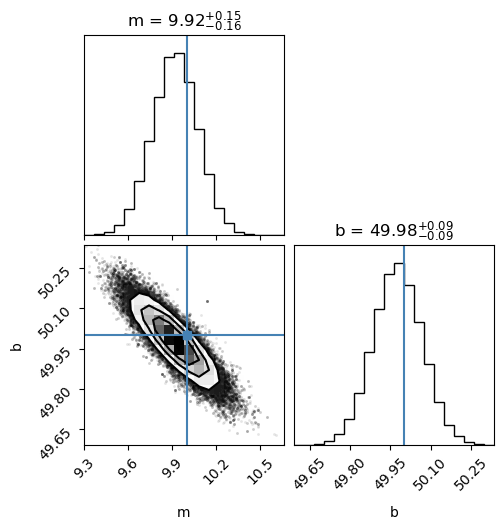

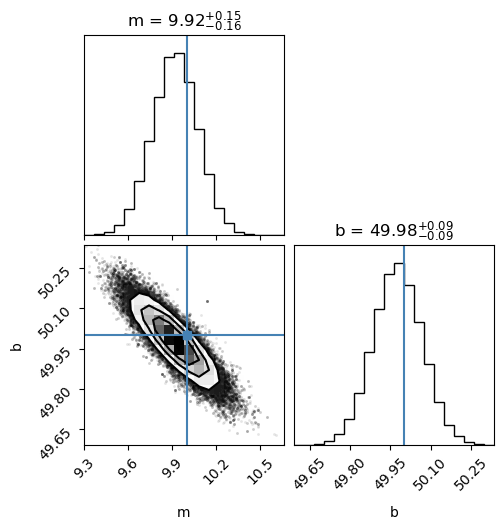

In [94]:
corner.corner(flat_chain, labels=['m','b'], truths=[true_m, true_b], show_titles=True)

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.